# OPTIVER - TRADING AT THE CLOSE

## Import Libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
%matplotlib inline

## Insert Data + Read Data

In [3]:
df = pd.read_csv('train.csv')
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [4]:
df = df[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,1,0,0,-5.519986
2,2,0,0,-8.389950
3,3,0,0,-4.010200
4,4,0,0,-7.349849
...,...,...,...,...
5237975,195,480,540,2.310276
5237976,196,480,540,-8.220077
5237977,197,480,540,1.169443
5237978,198,480,540,-1.540184


## Target before Training

<Axes: >

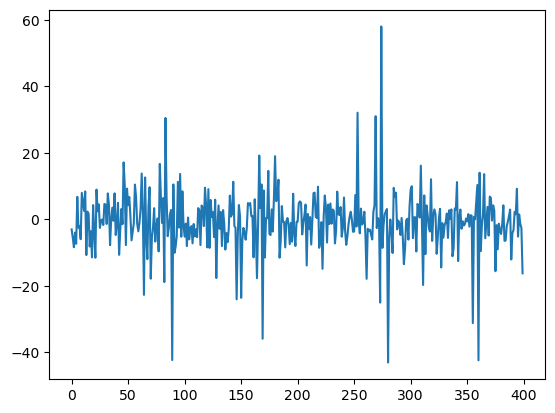

In [5]:
df.head(400)['target'].plot()

## Configuration Parameters

In [6]:
SEED = 42

N_LAGS = 55 # number of time lags used in the time series analysis.

BATCH_SIZE = 32
BUFFER_SIZE = 100000 # used for shuffling the data during training
EPOCHS = 100
PATIENCE = 25 # used as a parameter in early stopping
LEARNING_RATE = 1e-4

SPLIT_DAY = 390 # day on which the dataset is split into training and validation sets. 

# parameters define the size of the dataset, specifying the number of stocks, dates, and seconds
N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55

RUN_TRAINING = True # A boolean flag indicating whether to run the training process. If set to True, the model training code will be executed.

## Creating Index Combinations

In [7]:
# creating a lists of unique identifiers for stocks, dates, and seconds

all_stock_ids = range(N_STOCKS) # generates stock IDs
all_date_ids = range(N_DATES) # generates date IDs
all_seconds = [i * 10 for i in range(N_SECONDS)] # generates seconds in increments of 10

## Creating Multindex

In [8]:
# generateing all possible combinations of stock IDs, date IDs, and seconds, creating a hierarchical index

multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])

## Update DataFrame

In [9]:
df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index) # reindex method is used to align the DataFrame with the new MultiIndex created 

missing_values_count = df_full.isnull().sum()
print(missing_values_count)

target    53108
dtype: int64


## Fixing Null values

In [10]:
df_full = df_full.fillna(0) # Filling with 0
df_full = df_full.reset_index()

missing_values_count = df_full.isnull().sum()
print(missing_values_count)


stock_id             0
date_id              0
seconds_in_bucket    0
target               0
dtype: int64


## Assertion Check

In [11]:
assert(df_full.shape[0] == N_STOCKS * N_DATES * N_SECONDS) # ensures that the resulting DataFrame has the expected number of rows, which should be the product of the specified numbers of stocks, dates, and seconds
df_full

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,0,0,10,0.389814
2,0,0,20,4.220009
3,0,0,30,5.450249
4,0,0,40,3.169775
...,...,...,...,...
5290995,199,480,500,-7.209778
5290996,199,480,510,-9.750128
5290997,199,480,520,3.629923
5290998,199,480,530,4.760027


## Handling missing values in the Data

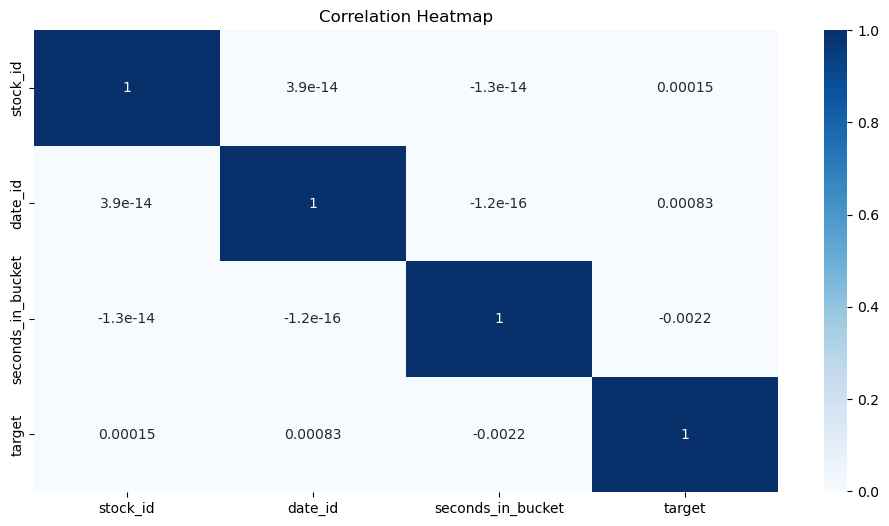

In [12]:
selected_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
selected_data = df_full[selected_columns]

plt.figure(figsize=(12,6))

sns.heatmap(selected_data.corr(), cmap="Blues", annot=True) #Dropping the first column bc it is date 
plt.title('Correlation Heatmap')
plt.show()

## Training the dataset

In [13]:
y = df_full['target'].values
x = df_full[['stock_id', 'date_id', 'seconds_in_bucket']].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

In [14]:
# Creating the Knn Model and the possible values for k
params = {'n_neighbors':[5,10,15,20,25,30,35]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=3) # 3 fold cross-validation

# fit the model
model.fit(x_train, y_train)

# Use model to make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

## Optimal K value

In [15]:
best_n_neighbors = model.best_params_['n_neighbors']
best_n_neighbors

35

## Training metrics

In [16]:
dframe_train = pd.DataFrame({'Actual':y_train.flatten(), 'Predicted':y_train_pred.flatten()}) ## so we are able to see the data better presented below
dframe_train

,Actual,Predicted
0,-9.369850,1.207386
1,3.800392,-1.407129
2,-7.889867,-6.094302
3,8.260012,-0.539695
4,4.580021,-2.857157
...,...,...
4232795,0.109673,-0.633121
4232796,-13.039708,3.760304
4232797,-26.959778,-2.612523
4232798,1.020431,0.885521


In [17]:
print('Training:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))
print('Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

Training:
Mean Absolute Error: 6.289972816889125
Mean Squared Error: 85.45748232482732
Root Mean Square Error: 9.244321625994377


## Presenting results with graphs

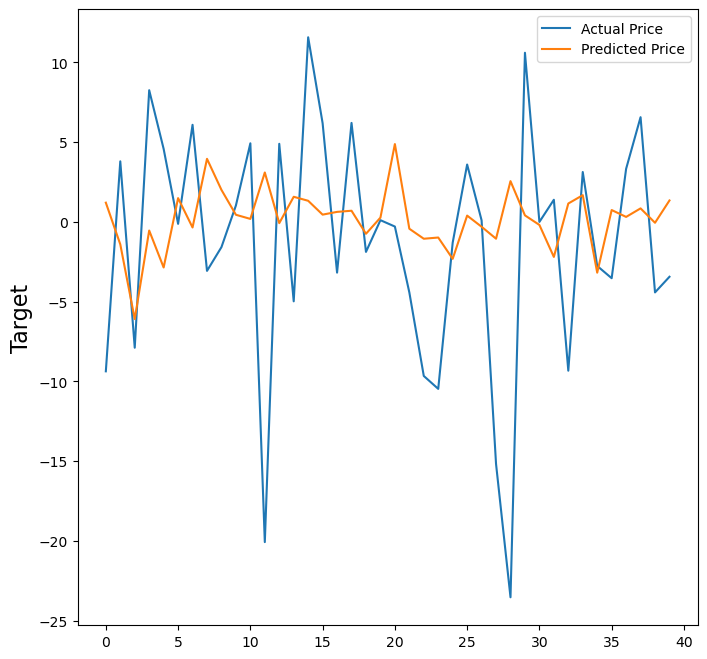

In [18]:
plt.figure(figsize=(8,8))
plt.ylabel('Target', fontsize=16)
plt.plot(dframe_train.head(40))
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

<Axes: >

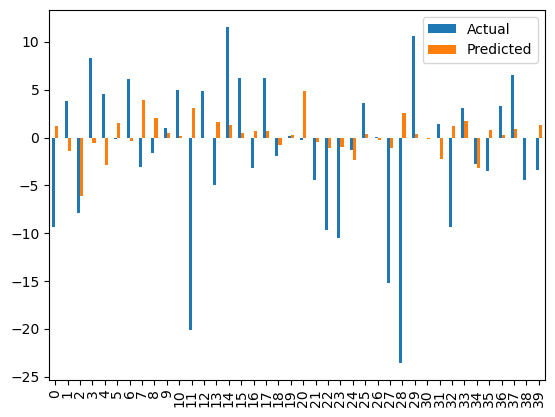

In [19]:
graph = dframe_train.head(40)
graph.plot(kind='bar')

## Testing metrics

In [20]:
dframe = pd.DataFrame({'Actual':y_test.flatten(), 'Predicted':y_test_pred.flatten()}) ## so we are able to see the data better presented below
dframe

,Actual,Predicted
0,25.780201,-2.607839
1,9.000301,-1.535995
2,2.709627,0.381061
3,11.069775,-0.927721
4,11.670589,0.627995
...,...,...
1058195,23.590326,1.524840
1058196,1.369715,-2.845986
1058197,5.849600,-2.725465
1058198,4.199743,0.429443


In [21]:
print('Test:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Test:
Mean Absolute Error: 6.465036875625601
Mean Squared Error: 90.4521873147549
Root Mean Square Error: 9.510635484275218


## Presenting results with graphs

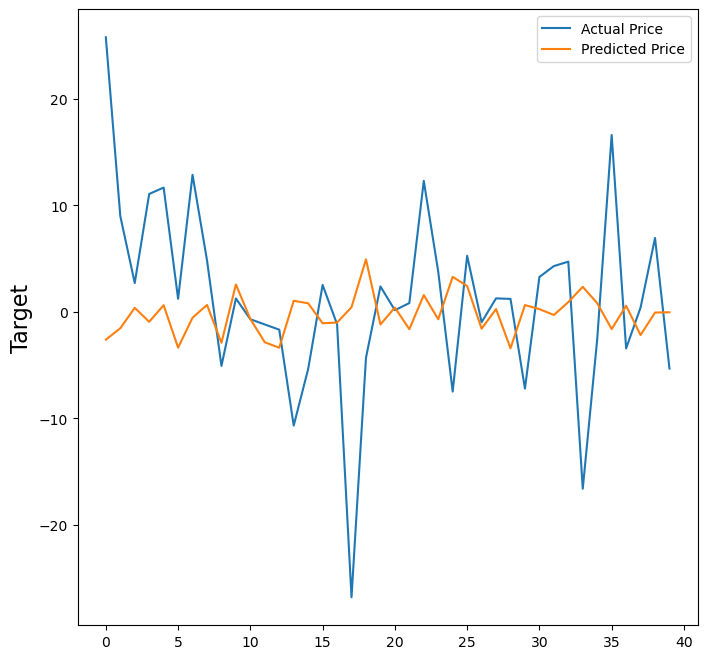

In [22]:
plt.figure(figsize=(8,8))
plt.ylabel('Target', fontsize=16)
plt.plot(dframe.head(40))
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

<Axes: >

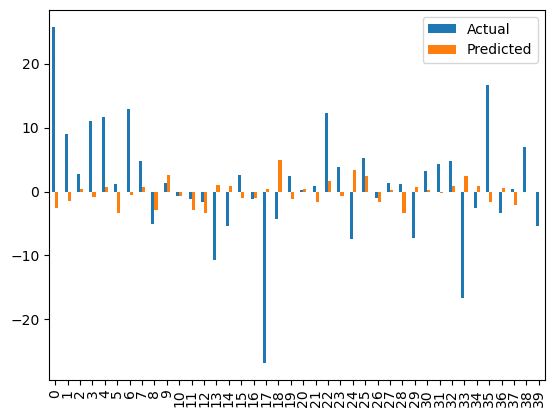

In [23]:
graph = dframe.head(40)
graph.plot(kind='bar')